# Client Churn Prediction
### CRISP-DM Cycle 4
---
The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional business case

## 0. Preparation

### 0.1 Imports & Settings

In [1]:
from IPython.core.display import HTML
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from src.utils_ml import (
    metrics_models,
    metrics_cv,
    plot_confusion_matrix,
    plot_roc_auc,
    plot_best_threshold_roc,
    threshold_tuning_plot,
    highlight_max,
)

In [2]:
def jupyter_settings():
    """
    Plots pre settings.
    """

    %matplotlib inline
    plt.style.use("seaborn-v0_8-whitegrid")
    plt.rcParams["figure.figsize"] = [25, 12]
    plt.rcParams["font.size"] = 24
    display(HTML("<style>.container {width:100% !important;}</style>"))
    sns.set()


jupyter_settings()

seed = 42

### 0.3 Path

In [3]:
# found the main project folders
path = Path().resolve().parent
data_path = path / "data/processed"

### 0.4 Data

This dataset is available [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clients credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimate of annual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [4]:
X_train = pd.read_parquet(data_path / "X_train_fs.parquet")
X_test = pd.read_parquet(data_path / "X_test_fs.parquet")
X_val = pd.read_parquet(data_path / "X_val_fs.parquet")
y_train = pd.read_pickle(data_path / "y_train.pkl")
y_test = pd.read_pickle(data_path / "y_test.pkl")
y_val = pd.read_pickle(data_path / "y_val.pkl")

## 4. ML Modelling

### 4.1 Settings and Models

In [5]:
proportion = float(len(y_train[y_train == 0])) / len(y_train[y_train == 1])

class_weights = {0: 0.8, 1: 0.2}


classifiers_list = [
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(
        class_weight=class_weights, solver="lbfgs", max_iter=500, random_state=seed
    ),
    DecisionTreeClassifier(class_weight=class_weights, random_state=seed),
    RandomForestClassifier(class_weight=class_weights, random_state=seed),
    AdaBoostClassifier(algorithm="SAMME", random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    ExtraTreesClassifier(class_weight=class_weights, random_state=seed),
    XGBClassifier(
        scale_pos_weight=proportion,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=seed,
    ),
    LGBMClassifier(
        is_unbalance=True,
        objective="binary",
        metric="binary_logloss",
        random_state=seed,
    ),
    CatBoostClassifier(scale_pos_weight=proportion, random_state=seed),
]

# Separating into four groups for a better view
model_list_1 = [
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(
        class_weight=class_weights, solver="lbfgs", max_iter=500, random_state=seed
    ),
]

model_list_2 = [
    DecisionTreeClassifier(class_weight=class_weights, random_state=seed),
    RandomForestClassifier(class_weight=class_weights, random_state=seed),
    ExtraTreesClassifier(class_weight=class_weights, random_state=seed),
]

model_list_3 = [
    AdaBoostClassifier(algorithm="SAMME", random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    XGBClassifier(
        scale_pos_weight=0.2,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=seed,
    ),
]

model_list_4 = [
    LGBMClassifier(
        is_unbalance=True,
        objective="binary",
        metric="binary_logloss",
        random_state=seed,
    ),
    CatBoostClassifier(class_weights=class_weights, random_state=seed),
]

### 4.2 Evaluation

Some information before start:

**Precision**: Precision is a metric used in classification tasks. It measures the proportion of true positive predictions (correctly predicted positive instances) out of all instances predicted as positive. It's a measure of the model's accuracy when it predicts positive results.

**Recall (Sensitivity)**: Recall, also known as sensitivity or true positive rate, measures the proportion of true positive predictions out of all actual positive instances. It's a measure of how well the model captures all positive instances.

**F1-Score**: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. It's particularly useful when you want to consider both false positives and false negatives and find a single metric that represents their trade-off.

**ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**: ROC-AUC is a metric used for evaluating the performance of binary classification models. It quantifies the ability of the model to distinguish between positive and negative classes by measuring the area under the receiver operating characteristic curve. A higher ROC-AUC value indicates a better model's ability to discriminate between the classes.

In churn cases, it's often better to evaluate the model using the F1-score but in this case, Recall is more relevant.


#### 4.2.1 Model Metrics 

In [6]:
metrics_result = metrics_models(
    classifiers_list, X_train, y_train, X_val, y_val, verbose=False
)

Please wait a moment - Doing ML


/Users/gutto/Repos/churn-ticket/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 1426, number of negative: 5574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203714 -> initscore=-1.363240
[LightGBM] [Info] Start training from score -1.363240
Learning rate set to 0.023648
0:	learn: 0.6804332	total: 64.3ms	remaining: 1m 4s
1:	learn: 0.6698844	total: 66.8ms	remaining: 33.3s
2:	learn: 0.6594798	total: 69ms	remaining: 22.9s
3:	learn: 0.6508297	total: 71.4ms	remaining: 17.8s
4:	learn: 0.6419314	total: 73.8ms	remaining: 14.7s
5:	learn: 0.6331423	total: 76ms	remaining: 12.6s
6:	learn: 0.6257940	total: 78.2ms	remaining: 11.1s
7:	learn: 0.6183194	total: 80.3ms	remaining: 9.96s
8:	learn: 0

In [7]:
metrics_result

,Model_Name,Balanced_Accuracy,Precision,Recall,F1 Score,ROCAUC
0,KNeighborsClassifier,0.545977,0.293413,0.240196,0.264151,0.545977
1,LogisticRegression,0.513450,0.750000,0.029412,0.056604,0.513450
2,DecisionTreeClassifier,0.702483,0.416129,0.632353,0.501946,0.702483
3,RandomForestClassifier,0.742598,0.718954,0.539216,0.616246,0.742598
4,AdaBoostClassifier,0.681631,0.776699,0.392157,0.521173,0.681631
5,GradientBoostingClassifier,0.721537,0.840708,0.465686,0.599369,0.721537
6,ExtraTreesClassifier,0.711043,0.800000,0.450980,0.576803,0.711043
7,XGBClassifier,0.742044,0.601010,0.583333,0.592040,0.742044
8,LGBMClassifier,0.761085,0.623762,0.617647,0.620690,0.761085
9,CatBoostClassifier,0.765162,0.707602,0.593137,0.645333,0.765162


#### 4.2.2 Cross-Validation Metrics

In [8]:
cv_result = metrics_cv(classifiers_list, X_train, y_train, verbose=False)

Please wait a moment - Doing CV


/Users/gutto/Repos/churn-ticket/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gutto/Repos/churn-ticket/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

[LightGBM] [Info] Number of positive: 1140, number of negative: 4460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3565
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203571 -> initscore=-1.364121
[LightGBM] [Info] Start training from score -1.364121
[LightGBM] [Info] Number of positive: 1141, number of negative: 4459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3560
[LightGBM] [Info] Number of data points in the train set: 5600, number of used features: 33
[LightGBM] [Info] [binar

In [9]:
cv_result.style.apply(highlight_max)

,Model_Name,Threshold,Balanced_Accuracy Mean,Balanced_Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Score Mean,F1 Score STD,ROCAUC Mean,ROCAUC STD
0,KNeighborsClassifier,0.500000,0.567000,0.017000,0.408000,0.039000,0.211000,0.037000,0.278000,0.041000,0.567000,0.567000
1,LogisticRegression,0.500000,0.536000,0.034000,0.601000,0.236000,0.110000,0.104000,0.148000,0.133000,0.536000,0.536000
2,DecisionTreeClassifier,0.500000,0.587000,0.078000,0.557000,0.203000,0.250000,0.216000,0.265000,0.198000,0.587000,0.587000
3,RandomForestClassifier,0.500000,0.618000,0.087000,0.595000,0.188000,0.306000,0.211000,0.341000,0.216000,0.618000,0.618000
4,AdaBoostClassifier,0.500000,0.633000,0.084000,0.621000,0.176000,0.330000,0.198000,0.379000,0.209000,0.633000,0.633000
5,GradientBoostingClassifier,0.500000,0.645000,0.082000,0.644000,0.170000,0.350000,0.187000,0.410000,0.204000,0.645000,0.645000
6,ExtraTreesClassifier,0.500000,0.654000,0.080000,0.651000,0.159000,0.367000,0.179000,0.431000,0.197000,0.654000,0.654000
7,XGBClassifier,0.500000,0.665000,0.080000,0.643000,0.150000,0.394000,0.182000,0.450000,0.191000,0.665000,0.665000
8,LGBMClassifier,0.500000,0.676000,0.082000,0.633000,0.144000,0.424000,0.192000,0.467000,0.186000,0.676000,0.676000
9,CatBoostClassifier,0.500000,0.686000,0.083000,0.625000,0.139000,0.451000,0.199000,0.482000,0.182000,0.686000,0.686000


Catboost seems promising

#### 4.2.3 ROCAUC

/Users/gutto/Repos/churn-ticket/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


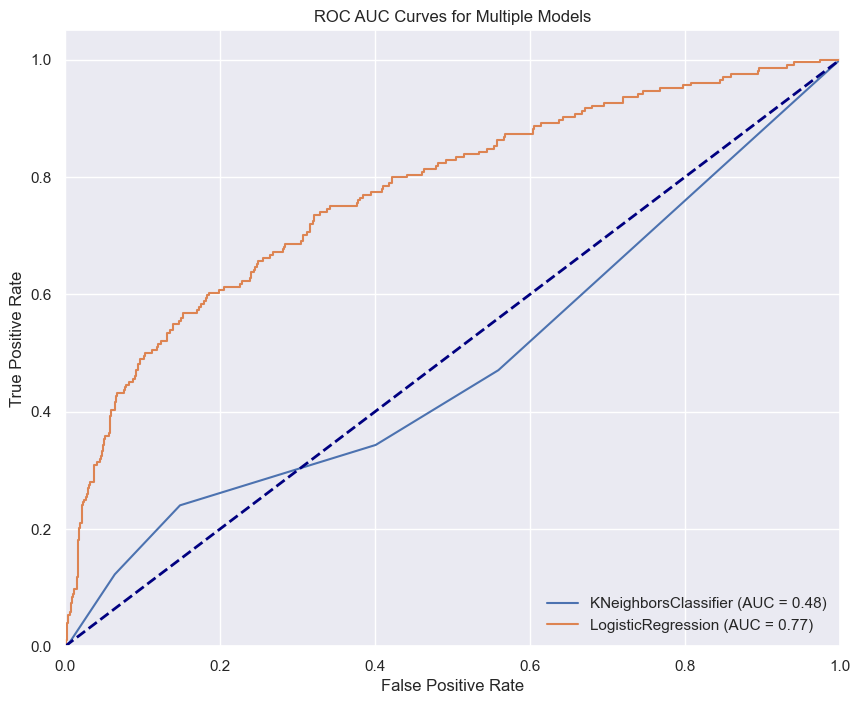

In [10]:
plot_roc_auc(model_list_1, X_train, y_train, X_val, y_val)

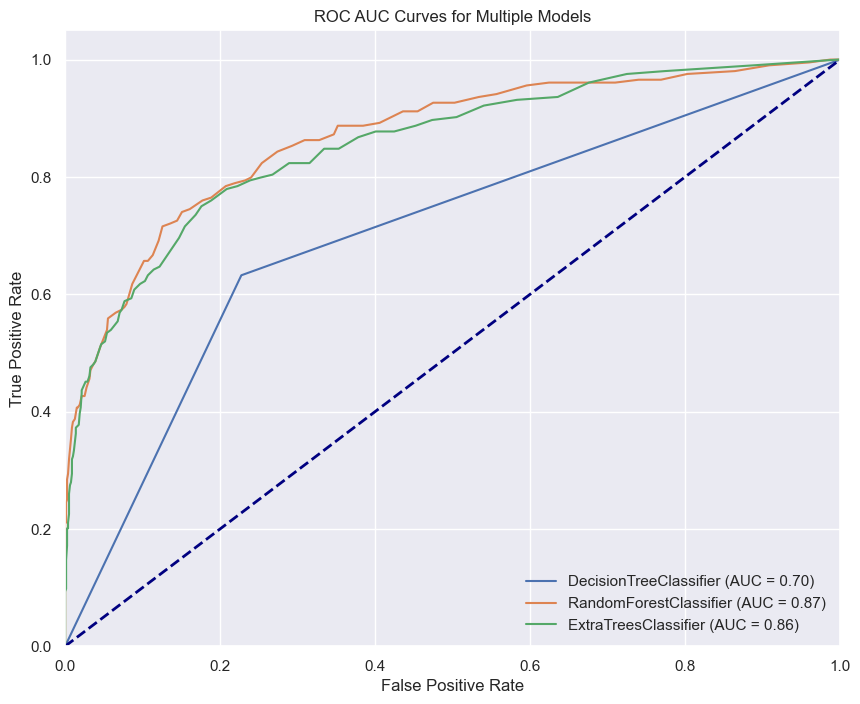

In [11]:
plot_roc_auc(model_list_2, X_train, y_train, X_val, y_val)

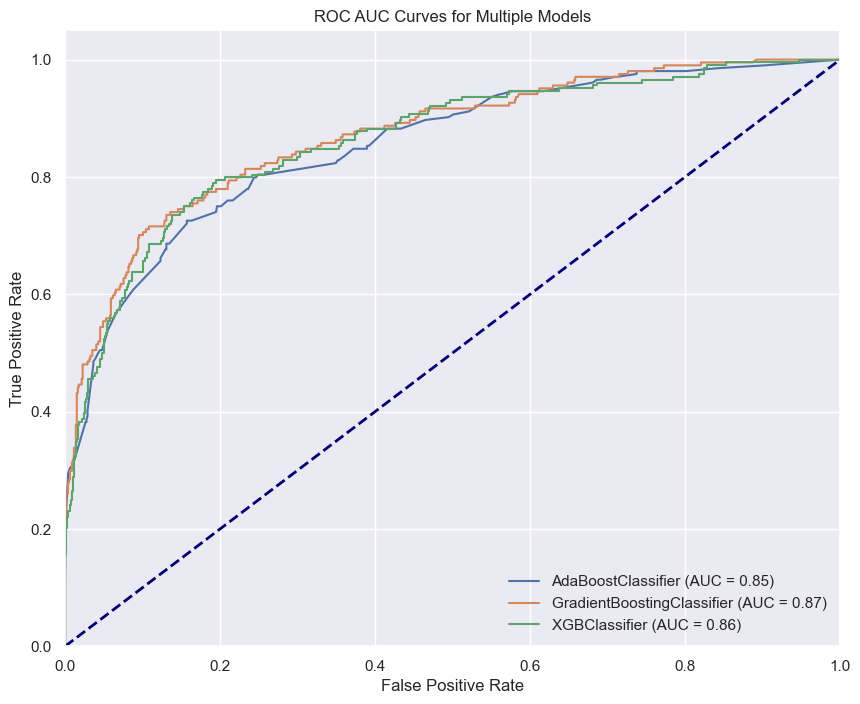

In [12]:
plot_roc_auc(model_list_3, X_train, y_train, X_val, y_val)

[LightGBM] [Info] Number of positive: 1426, number of negative: 5574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3566
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203714 -> initscore=-1.363240
[LightGBM] [Info] Start training from score -1.363240
Learning rate set to 0.023648
0:	learn: 0.6614646	total: 3.92ms	remaining: 3.92s
1:	learn: 0.6310407	total: 6.28ms	remaining: 3.14s
2:	learn: 0.6016618	total: 9.6ms	remaining: 3.19s
3:	learn: 0.5733691	total: 17.9ms	remaining: 4.45s
4:	learn: 0.5478342	total: 21ms	remaining: 4.17s
5:	learn: 0.5261501	total: 23.8ms	remaining: 3.94s
6:	learn: 0.5044996	total: 26.4ms	remaining: 3.75s
7:	learn: 0.4829277	total: 28.9ms	remaining: 3.58s
8:	learn: 

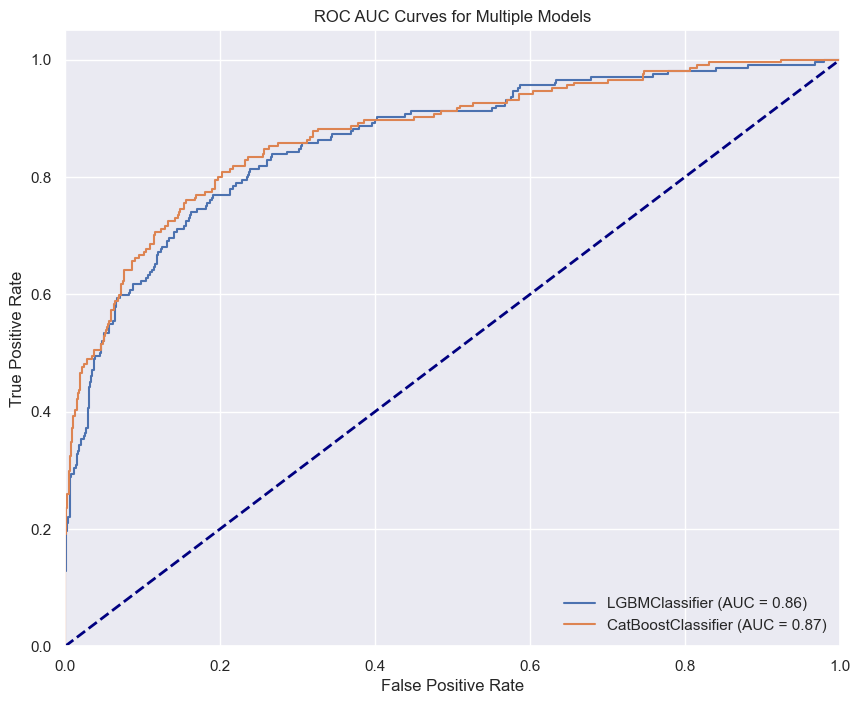

In [13]:
plot_roc_auc(model_list_4, X_train, y_train, X_val, y_val)

#### 4.2.4 Best Threshold

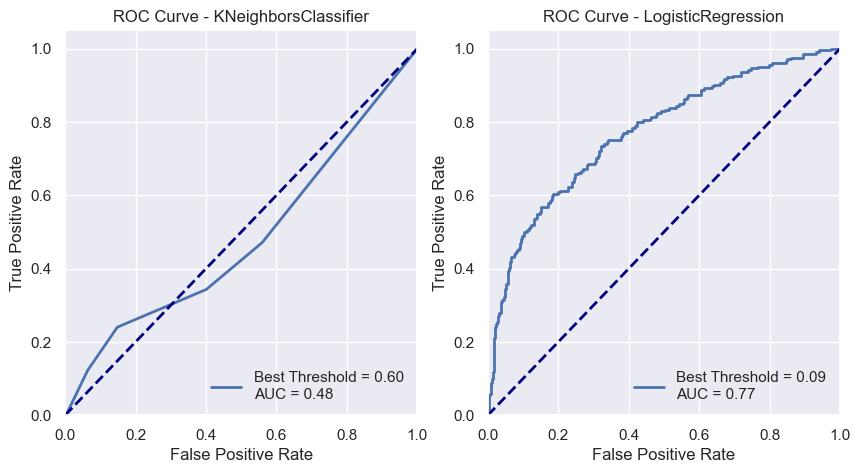

In [14]:
plot_best_threshold_roc(model_list_1, X_val, y_val)

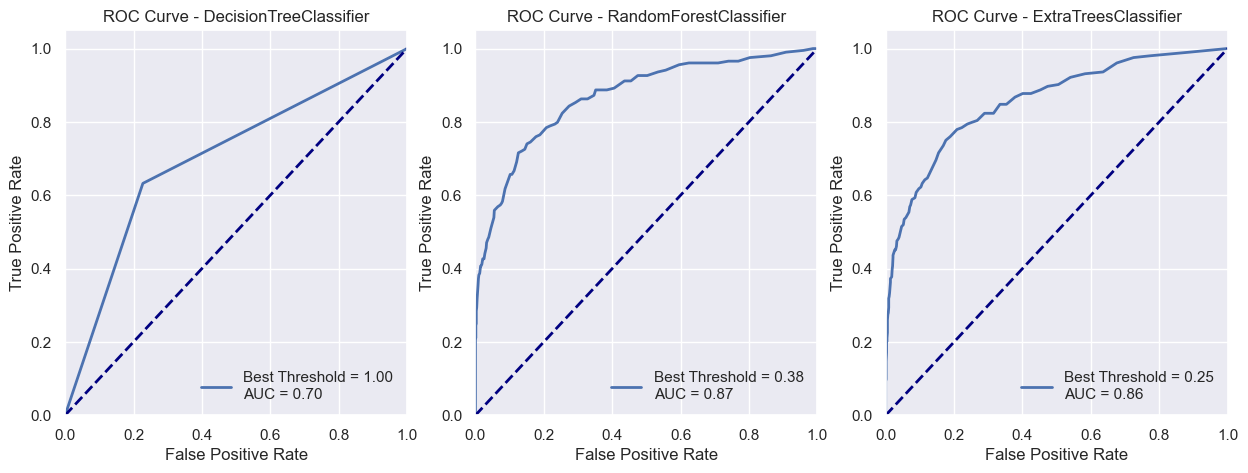

In [15]:
plot_best_threshold_roc(model_list_2, X_val, y_val)

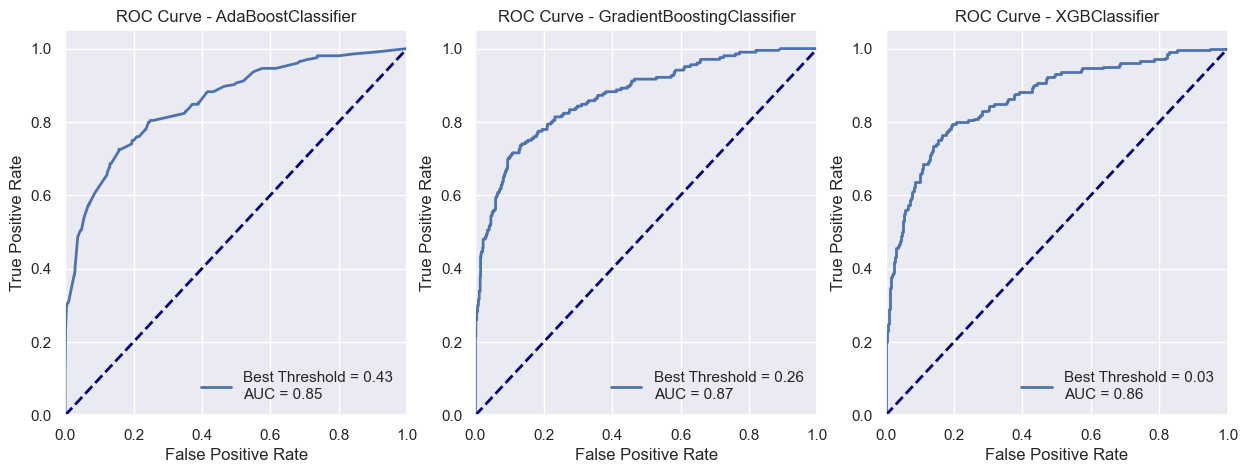

In [16]:
plot_best_threshold_roc(model_list_3, X_val, y_val)

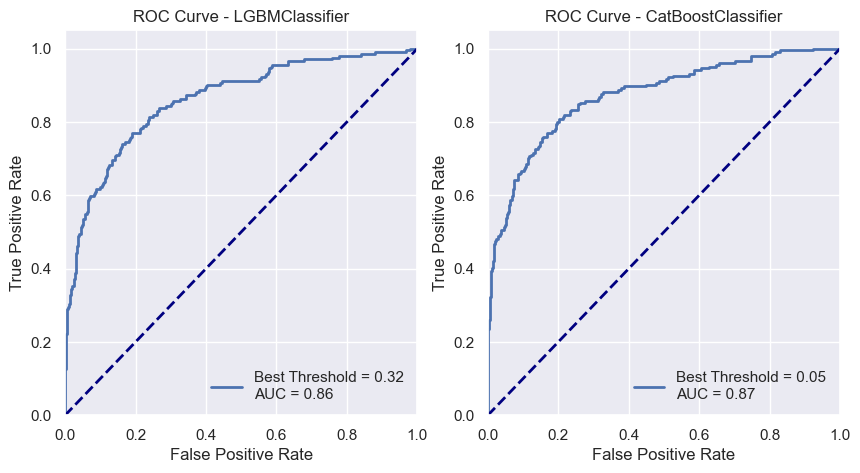

In [17]:
plot_best_threshold_roc(model_list_4, X_val, y_val)

#### 4.2.5 Confusion Matrix

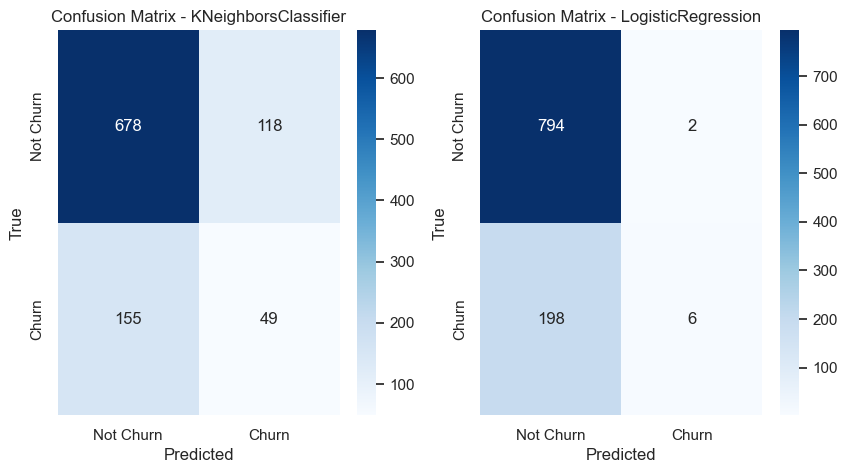

In [18]:
plot_confusion_matrix(model_list_1, X_val, y_val)

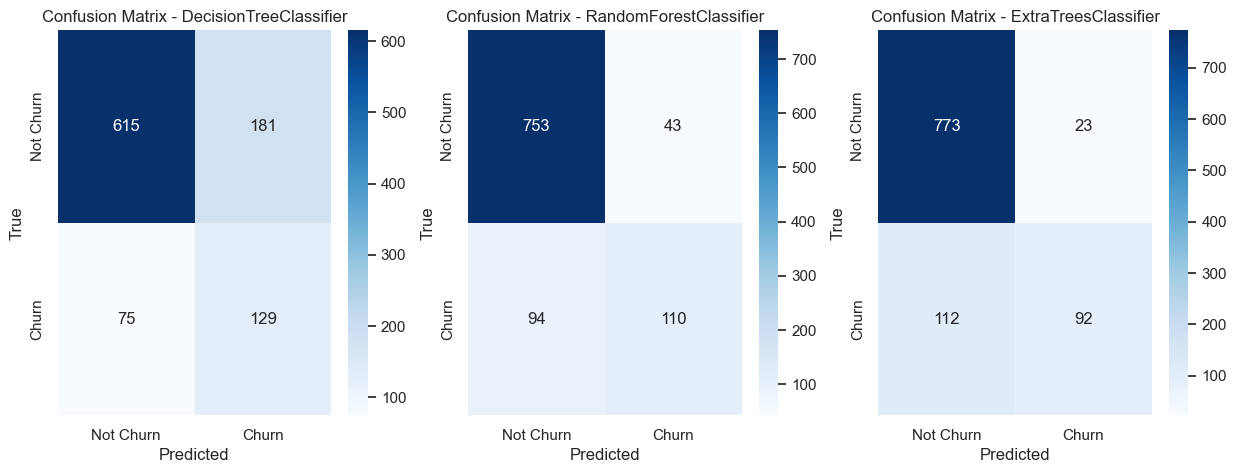

In [19]:
plot_confusion_matrix(model_list_2, X_val, y_val)

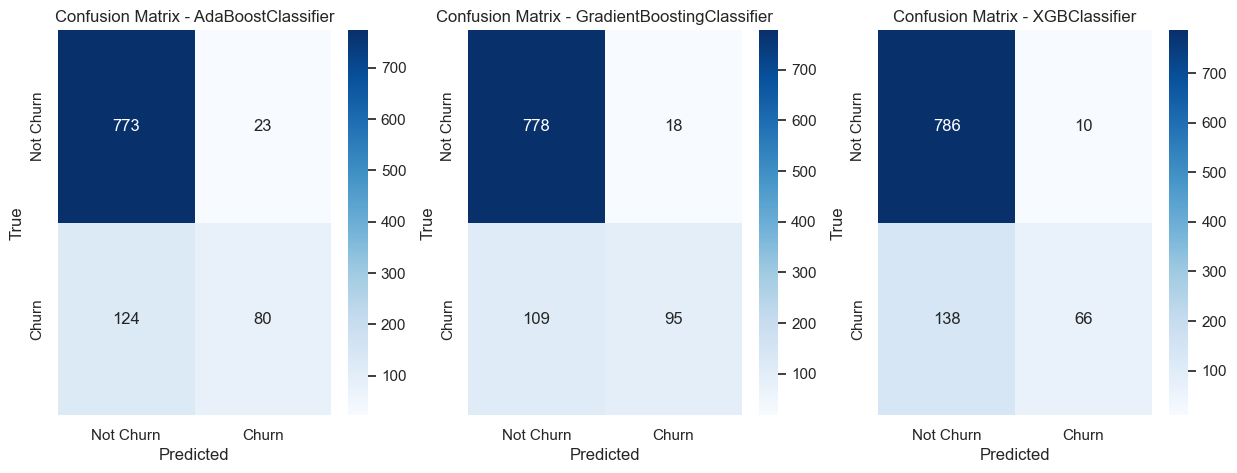

In [20]:
plot_confusion_matrix(model_list_3, X_val, y_val)

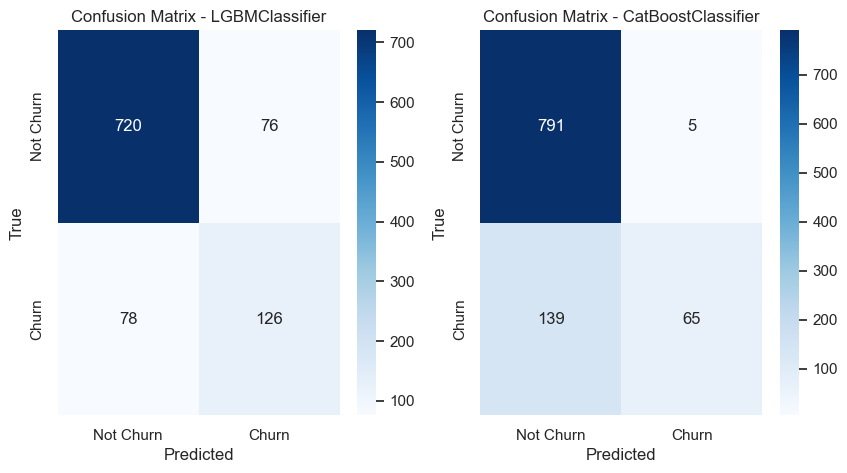

In [21]:
plot_confusion_matrix(model_list_4, X_val, y_val)

#### 4.2.6 Threshold Tuning with Confusion Matrix

In [22]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

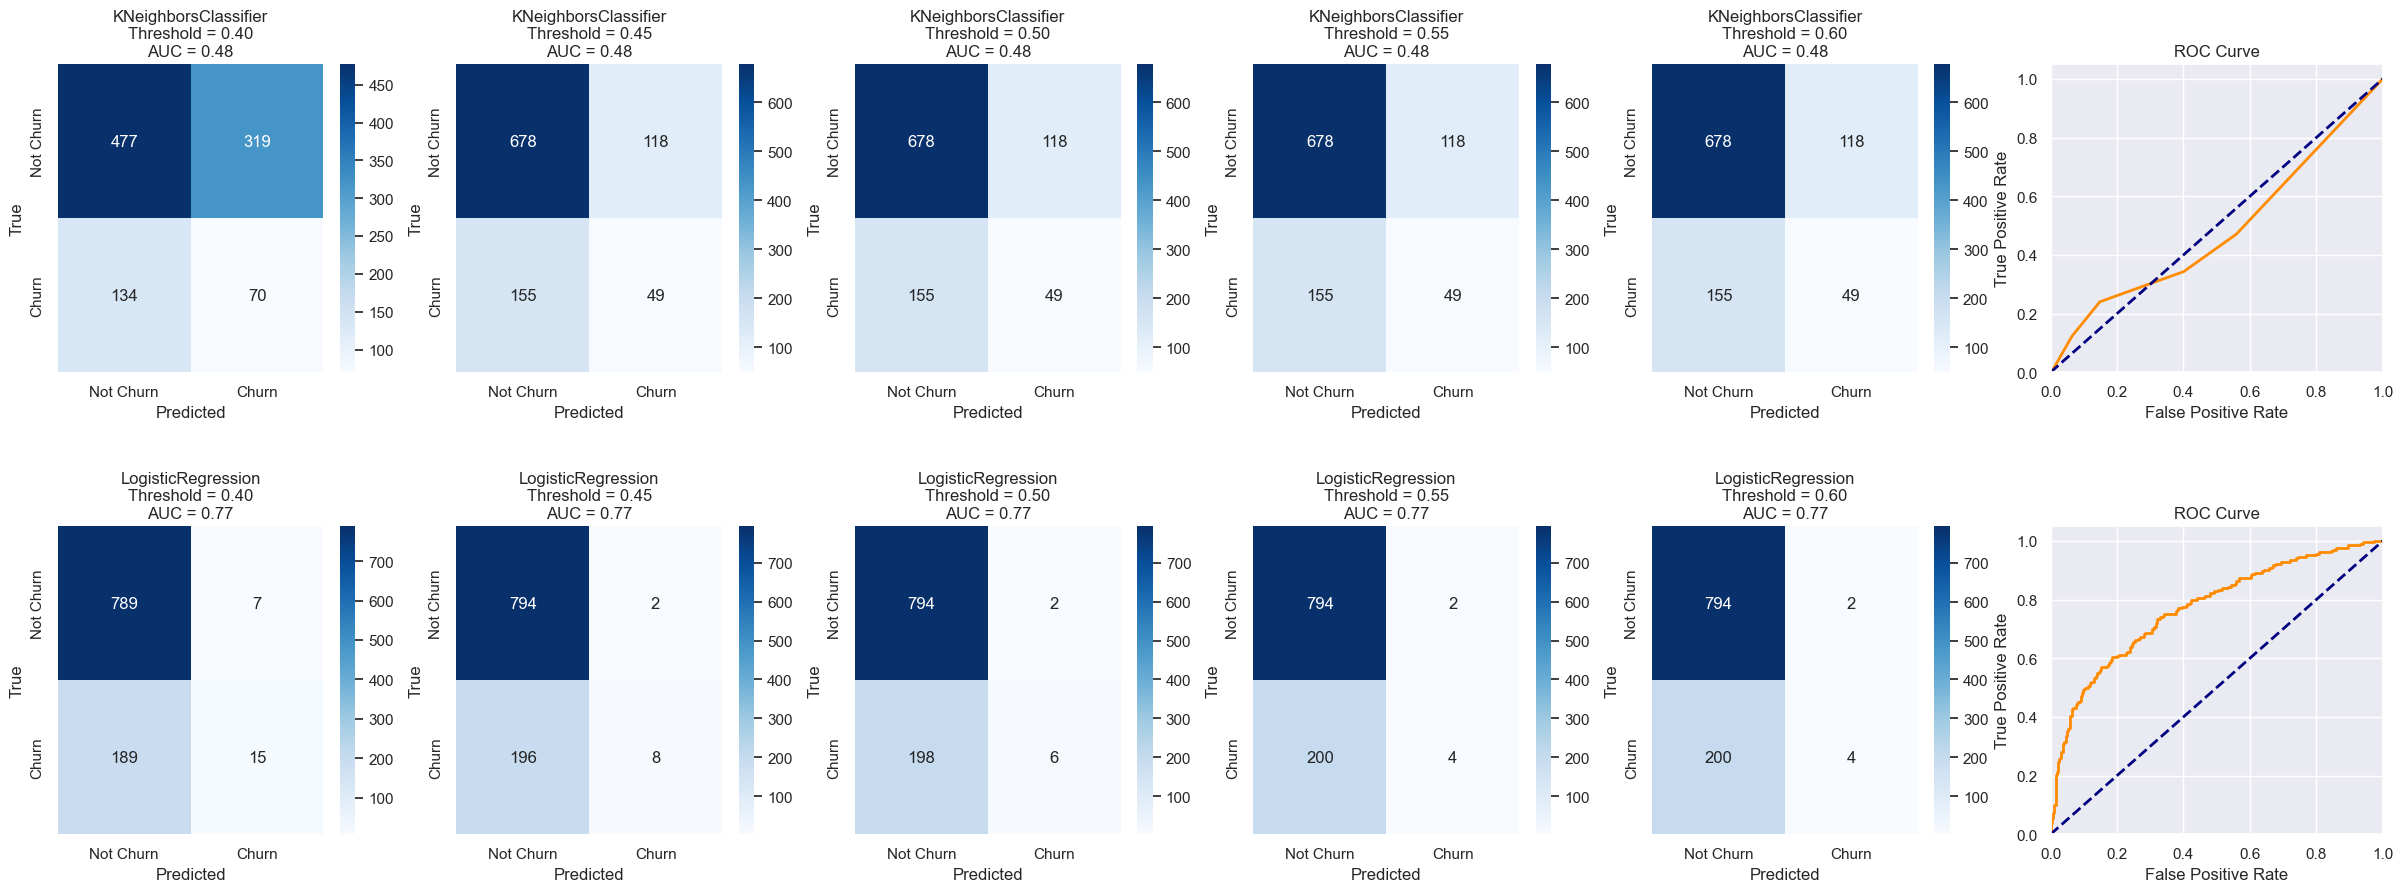

In [23]:
threshold_tuning_plot(model_list_1, X_val, y_val, thresholds)

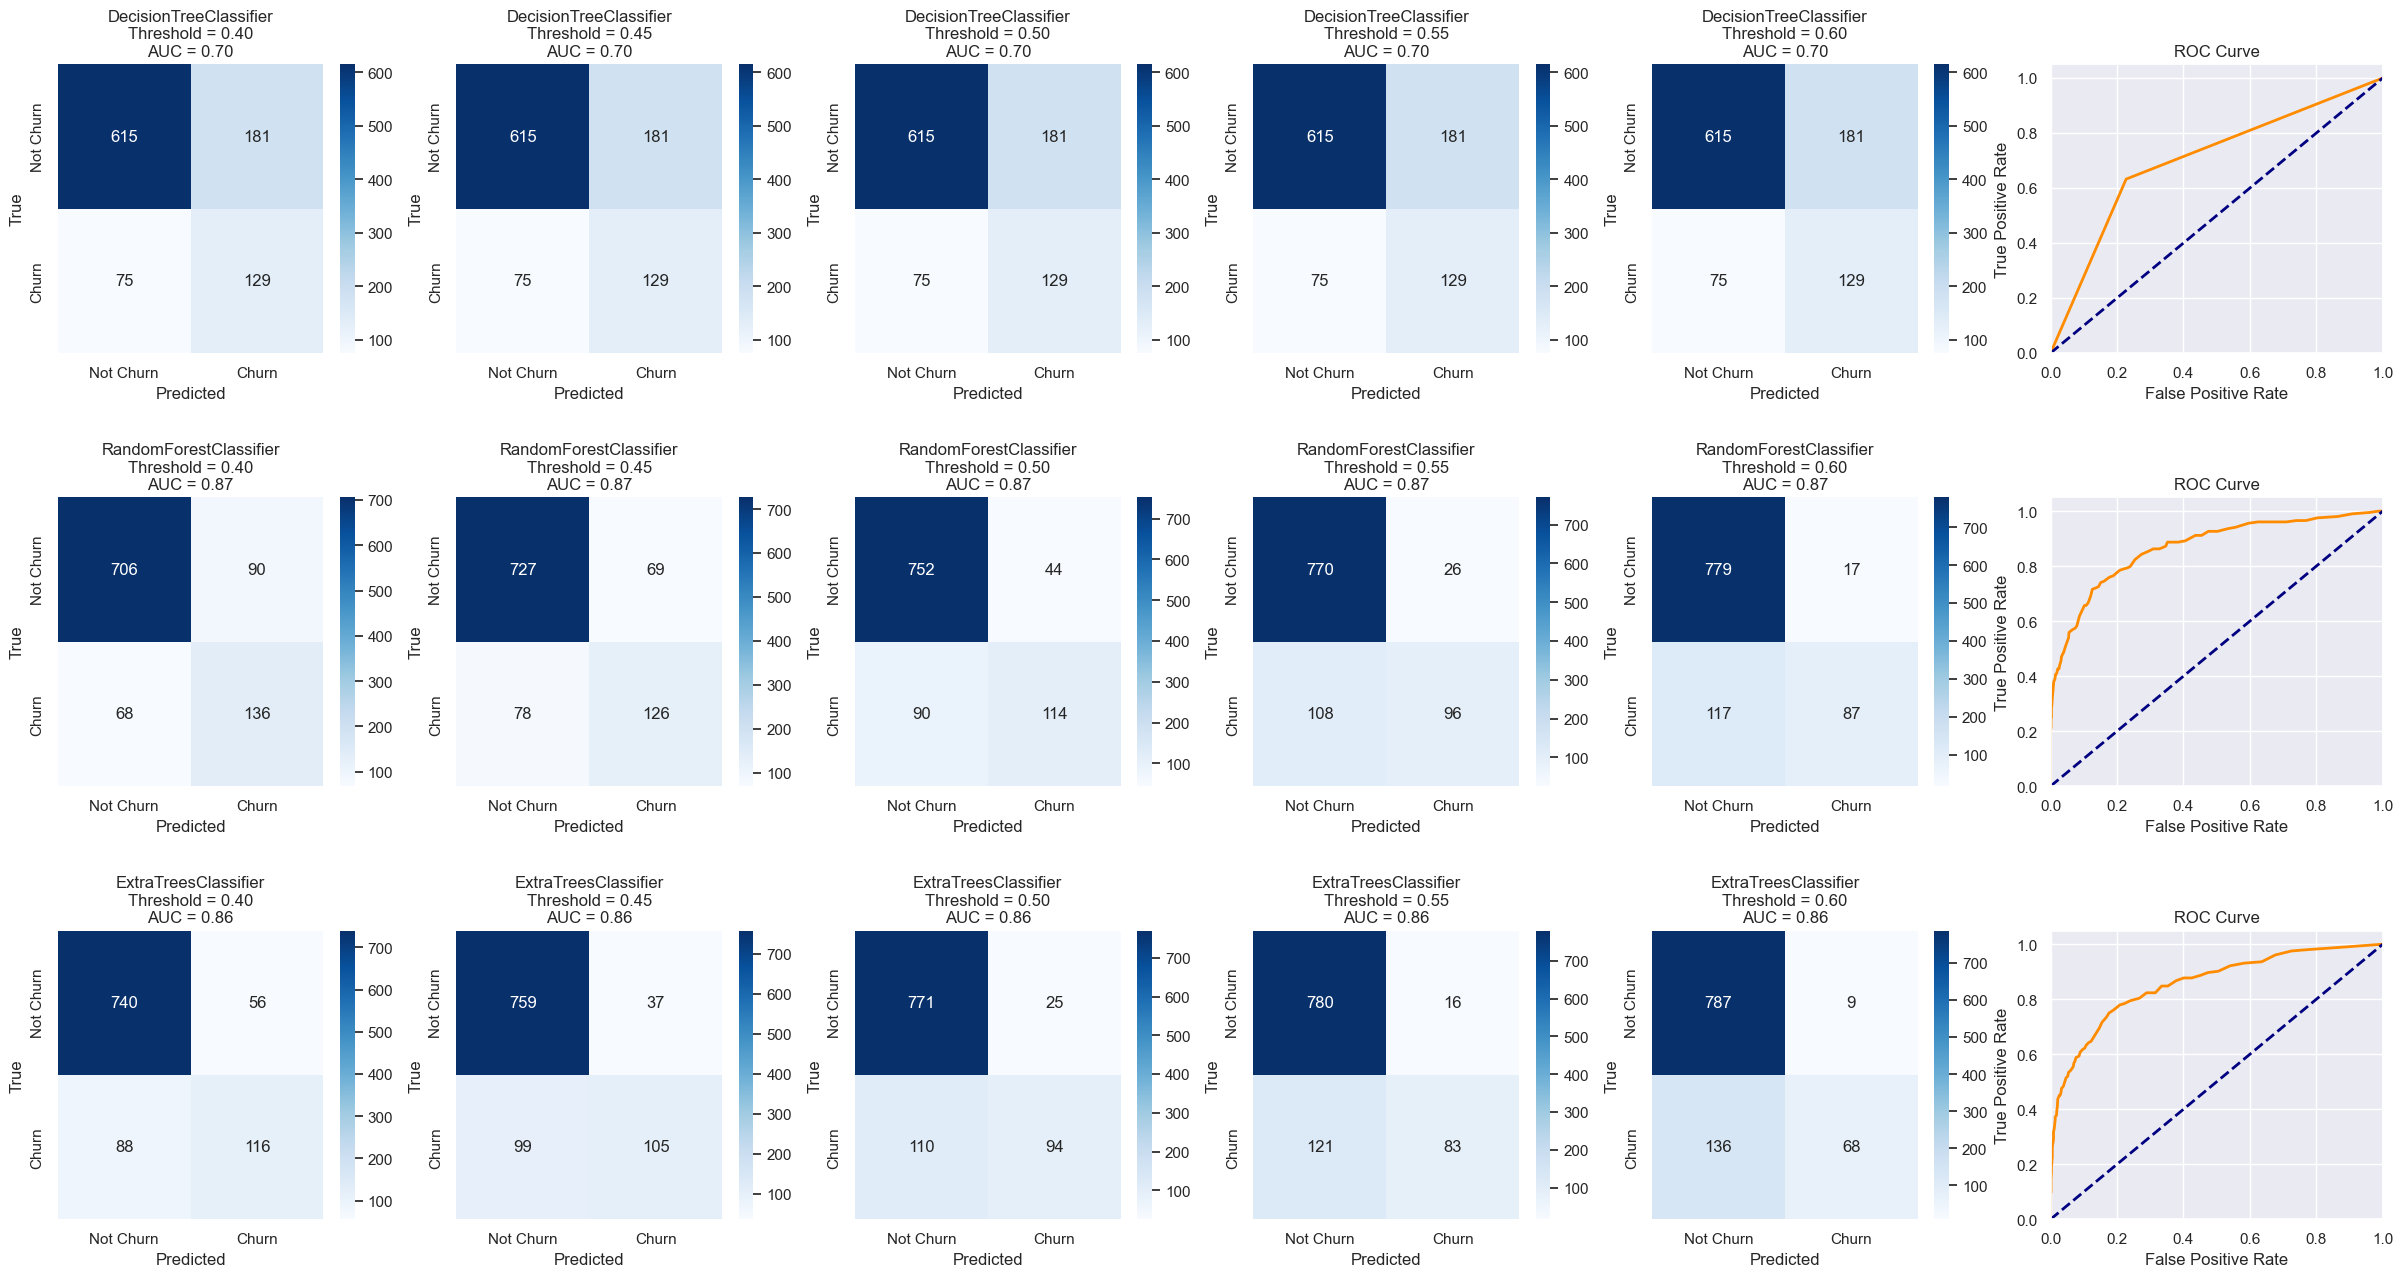

In [24]:
threshold_tuning_plot(model_list_2, X_val, y_val, thresholds)

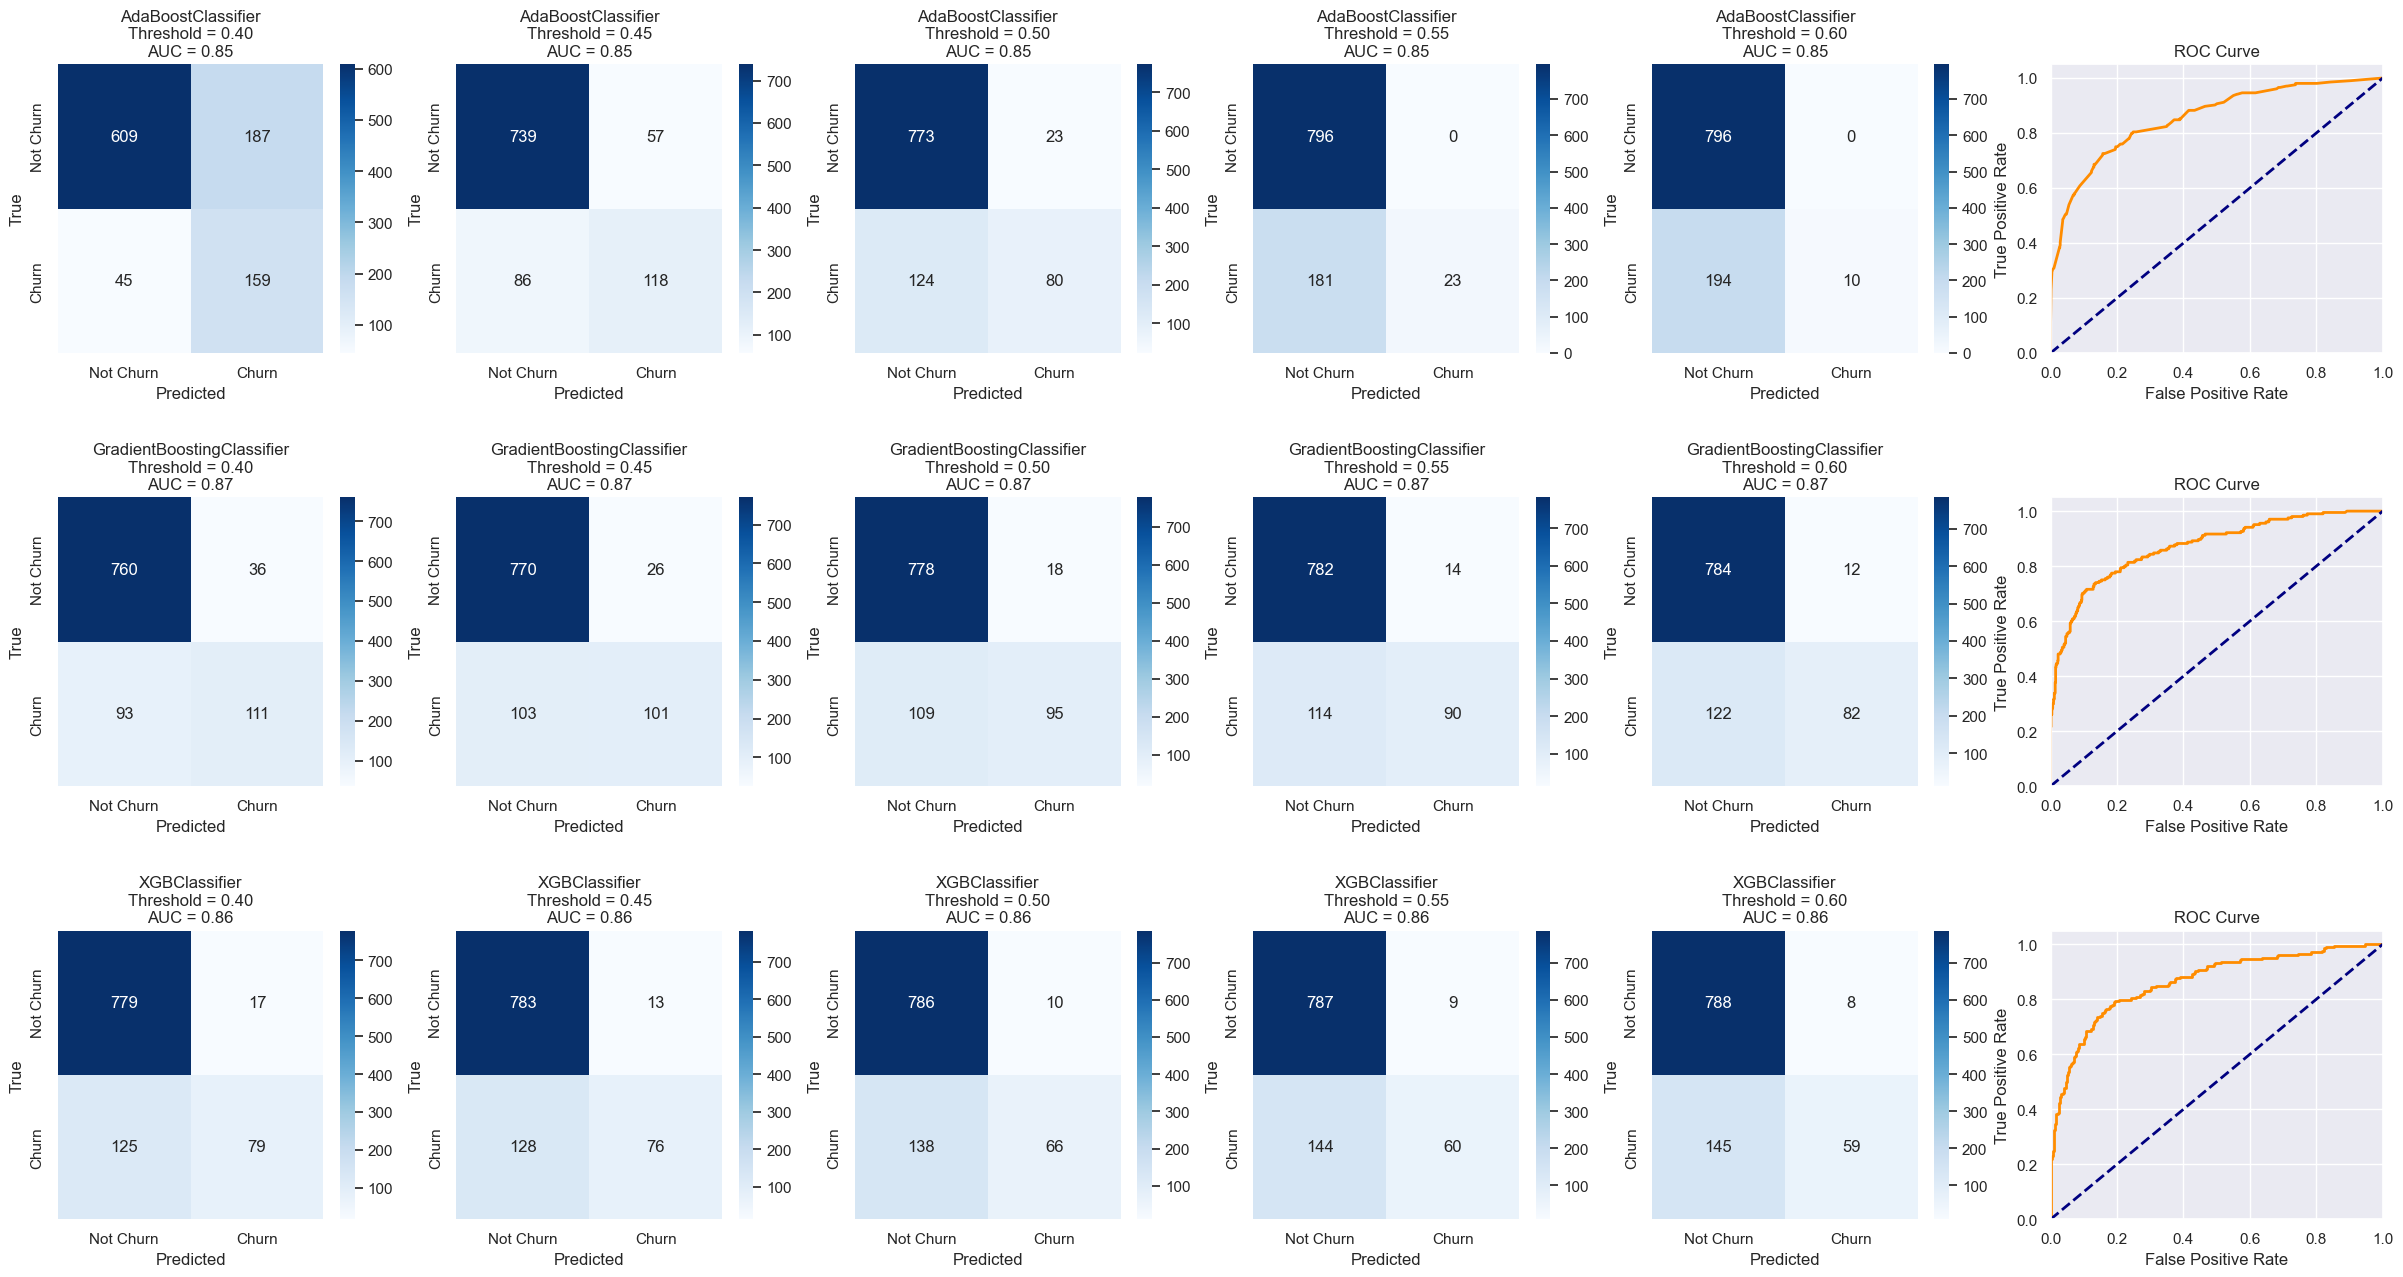

In [25]:
threshold_tuning_plot(model_list_3, X_val, y_val, thresholds)

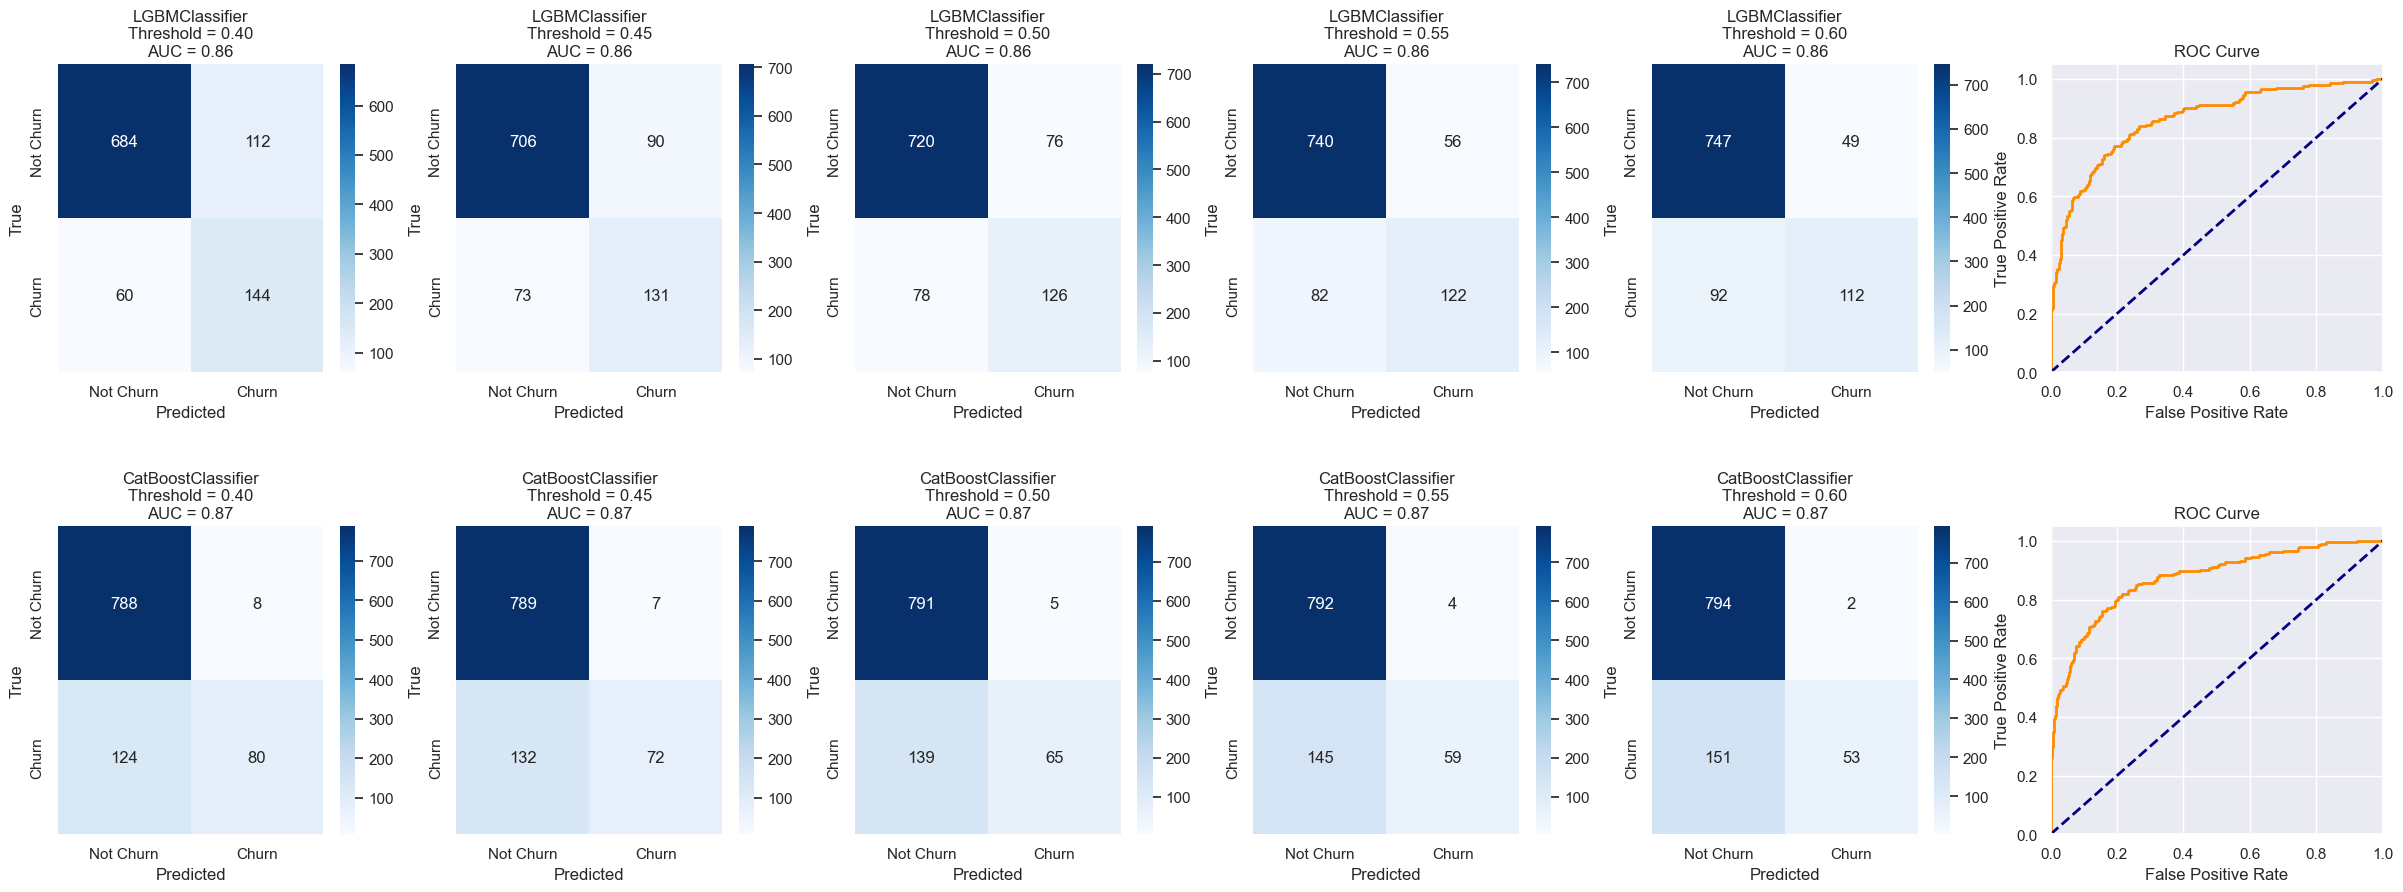

In [26]:
threshold_tuning_plot(model_list_4, X_val, y_val, thresholds)

#### 4.2.7 Final Model Selection

In [27]:
evaluation_list = [
    RandomForestClassifier(class_weight=class_weights, random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    XGBClassifier(
        scale_pos_weight=proportion,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=seed,
    ),
    LGBMClassifier(
        is_unbalance=True,
        objective="binary",
        metric="binary_logloss",
        random_state=seed,
        verbose=-1,
    ),
    CatBoostClassifier(scale_pos_weight=proportion, random_state=seed, verbose=0),
]

- `Thresholds`: 0.4, 0.45, 0.5, 0.55, 0.6

In [28]:
threshold_40 = metrics_cv(
    evaluation_list, X_train, y_train, threshold=0.4, verbose=False
)

Please wait a moment - Doing CV
Finished, check the results


In [29]:
threshold_45 = metrics_cv(
    evaluation_list, X_train, y_train, threshold=0.45, verbose=False
)

Please wait a moment - Doing CV
Finished, check the results


In [30]:
threshold_50 = metrics_cv(
    evaluation_list, X_train, y_train, threshold=0.5, verbose=False
)

Please wait a moment - Doing CV
Finished, check the results


In [31]:
threshold_55 = metrics_cv(
    evaluation_list, X_train, y_train, threshold=0.55, verbose=False
)

Please wait a moment - Doing CV
Finished, check the results


In [32]:
threshold_60 = metrics_cv(
    evaluation_list, X_train, y_train, threshold=0.6, verbose=False
)

Please wait a moment - Doing CV
Finished, check the results


In [33]:
threshold_result = pd.concat(
    [threshold_40, threshold_45, threshold_50, threshold_55, threshold_60], axis=0
).reset_index(drop=True)
threshold_result.style.apply(highlight_max)

,Model_Name,Threshold,Balanced_Accuracy Mean,Balanced_Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Score Mean,F1 Score STD,ROCAUC Mean,ROCAUC STD
0,RandomForestClassifier,0.400000,0.737000,0.021000,0.619000,0.024000,0.562000,0.043000,0.589000,0.030000,0.737000,0.737000
1,GradientBoostingClassifier,0.400000,0.735000,0.022000,0.654000,0.043000,0.545000,0.049000,0.592000,0.032000,0.735000,0.735000
2,XGBClassifier,0.400000,0.741000,0.021000,0.617000,0.063000,0.578000,0.065000,0.591000,0.027000,0.741000,0.741000
3,LGBMClassifier,0.400000,0.749000,0.023000,0.588000,0.075000,0.617000,0.089000,0.592000,0.024000,0.749000,0.749000
4,CatBoostClassifier,0.400000,0.754000,0.024000,0.568000,0.078000,0.645000,0.099000,0.592000,0.022000,0.754000,0.754000
5,RandomForestClassifier,0.450000,0.720000,0.019000,0.657000,0.036000,0.508000,0.040000,0.572000,0.032000,0.720000,0.720000
6,GradientBoostingClassifier,0.450000,0.720000,0.019000,0.691000,0.048000,0.498000,0.042000,0.577000,0.032000,0.720000,0.720000
7,XGBClassifier,0.450000,0.728000,0.021000,0.648000,0.073000,0.536000,0.067000,0.580000,0.027000,0.728000,0.728000
8,LGBMClassifier,0.450000,0.738000,0.026000,0.618000,0.081000,0.576000,0.092000,0.585000,0.026000,0.738000,0.738000
9,CatBoostClassifier,0.450000,0.746000,0.028000,0.599000,0.083000,0.606000,0.103000,0.589000,0.025000,0.746000,0.746000


Catboost showed better results compared with the rest of the evaluation list, especially with thresholds lower than 0.5.

In [34]:
catboost_list = [
    CatBoostClassifier(scale_pos_weight=proportion, random_state=seed, verbose=0)
]

catboost_40 = metrics_cv(catboost_list, X_train, y_train, threshold=0.4, verbose=False)
catboost_41 = metrics_cv(catboost_list, X_train, y_train, threshold=0.41, verbose=False)
catboost_42 = metrics_cv(catboost_list, X_train, y_train, threshold=0.42, verbose=False)
catboost_43 = metrics_cv(catboost_list, X_train, y_train, threshold=0.43, verbose=False)
catboost_44 = metrics_cv(catboost_list, X_train, y_train, threshold=0.44, verbose=False)
catboost_45 = metrics_cv(catboost_list, X_train, y_train, threshold=0.45, verbose=False)
catboost_46 = metrics_cv(catboost_list, X_train, y_train, threshold=0.46, verbose=False)
catboost_47 = metrics_cv(catboost_list, X_train, y_train, threshold=0.47, verbose=False)
catboost_48 = metrics_cv(catboost_list, X_train, y_train, threshold=0.48, verbose=False)
catboost_49 = metrics_cv(catboost_list, X_train, y_train, threshold=0.49, verbose=False)
catboost_50 = metrics_cv(catboost_list, X_train, y_train, threshold=0.5, verbose=False)
catboost_51 = metrics_cv(catboost_list, X_train, y_train, threshold=0.51, verbose=False)
catboost_52 = metrics_cv(catboost_list, X_train, y_train, threshold=0.52, verbose=False)
catboost_53 = metrics_cv(catboost_list, X_train, y_train, threshold=0.53, verbose=False)
catboost_54 = metrics_cv(catboost_list, X_train, y_train, threshold=0.54, verbose=False)
catboost_55 = metrics_cv(catboost_list, X_train, y_train, threshold=0.55, verbose=False)
catboost_56 = metrics_cv(catboost_list, X_train, y_train, threshold=0.56, verbose=False)
catboost_57 = metrics_cv(catboost_list, X_train, y_train, threshold=0.57, verbose=False)
catboost_58 = metrics_cv(catboost_list, X_train, y_train, threshold=0.58, verbose=False)
catboost_59 = metrics_cv(catboost_list, X_train, y_train, threshold=0.59, verbose=False)
catboost_60 = metrics_cv(catboost_list, X_train, y_train, threshold=0.6, verbose=False)

catboost_result = pd.concat(
    [
        catboost_40,
        catboost_41,
        catboost_42,
        catboost_43,
        catboost_44,
        catboost_45,
        catboost_46,
        catboost_47,
        catboost_48,
        catboost_49,
        catboost_50,
        catboost_51,
        catboost_52,
        catboost_53,
        catboost_54,
        catboost_55,
        catboost_56,
        catboost_57,
        catboost_58,
        catboost_59,
        catboost_60,
    ],
    axis=0,
).reset_index(drop=True)
catboost_result.style.apply(highlight_max)

Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished, check the results
Please wait a moment - Doing CV
Finished

,Model_Name,Threshold,Balanced_Accuracy Mean,Balanced_Accuracy STD,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Score Mean,F1 Score STD,ROCAUC Mean,ROCAUC STD
0,CatBoostClassifier,0.400000,0.777000,0.010000,0.489000,0.017000,0.757000,0.037000,0.593000,0.010000,0.777000,0.777000
1,CatBoostClassifier,0.410000,0.778000,0.011000,0.496000,0.016000,0.752000,0.038000,0.597000,0.009000,0.778000,0.778000
2,CatBoostClassifier,0.420000,0.778000,0.012000,0.502000,0.014000,0.745000,0.039000,0.599000,0.010000,0.778000,0.778000
3,CatBoostClassifier,0.430000,0.777000,0.010000,0.508000,0.016000,0.738000,0.035000,0.601000,0.008000,0.777000,0.777000
4,CatBoostClassifier,0.440000,0.777000,0.011000,0.516000,0.017000,0.731000,0.036000,0.604000,0.010000,0.777000,0.777000
5,CatBoostClassifier,0.450000,0.777000,0.012000,0.522000,0.016000,0.724000,0.037000,0.606000,0.011000,0.777000,0.777000
6,CatBoostClassifier,0.460000,0.777000,0.012000,0.530000,0.017000,0.718000,0.038000,0.609000,0.011000,0.777000,0.777000
7,CatBoostClassifier,0.470000,0.777000,0.012000,0.537000,0.015000,0.711000,0.040000,0.611000,0.008000,0.777000,0.777000
8,CatBoostClassifier,0.480000,0.776000,0.012000,0.544000,0.013000,0.703000,0.038000,0.613000,0.008000,0.776000,0.776000
9,CatBoostClassifier,0.490000,0.777000,0.012000,0.554000,0.011000,0.698000,0.036000,0.617000,0.010000,0.777000,0.777000


Let's try 0.43, 047 and 0.5